<a href="https://colab.research.google.com/github/borhan374/Introduction_to_Machine_Learning/blob/main/DT_Block_Chain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#فاز ۱: شبیه سازی شبکه واقعی همراه با DER
# نصب pandapower اگر نصب نیست
try:
    import pandapower as pp
    import pandapower.networks as pn
except ImportError:
    import sys
    !{sys.executable} -m pip install pandapower
    import pandapower as pp
    import pandapower.networks as pn

# ایجاد شبکه فشار متوسط واقعی CIGRE
net = pn.create_cigre_network_mv()

# نمایش باس‌های موجود
print("Bus indices in CIGRE MV network:", list(net.bus.index))

# انتخاب باس‌های معتبر برای افزودن DER و باتری
# ما فقط باس‌هایی را انتخاب می‌کنیم که وجود دارند
pv_bus = 1    # باس معتبر برای منبع خورشیدی
wind_bus = 3  # باس معتبر برای منبع بادی
battery_bus = 5  # باس معتبر برای باتری

# افزودن منابع انرژی پراکنده (DER)
pp.create_sgen(net, bus=pv_bus, p_mw=0.5, q_mvar=0.0, name="PV_Plant")
pp.create_sgen(net, bus=wind_bus, p_mw=0.4, q_mvar=0.0, name="Wind_Plant")

# افزودن باتری ذخیره‌ساز
pp.create_storage(net, bus=battery_bus, p_mw=0.2, max_e_mwh=0.5,
                  soc_percent=60.0, min_e_mwh=0.1, name="Battery")

# اجرای شبیه‌سازی پخش بار
pp.runpp(net)

# نمایش نتایج
print("\nVoltage at buses (pu):")
print(net.res_bus[["vm_pu"]])

print("\nDER Output:")
print(net.res_sgen)

print("\nBattery Storage Output:")
print(net.res_storage)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
Bus indices in CIGRE MV network: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

Voltage at buses (pu):
       vm_pu
0   1.030000
1   0.992567
2   0.969649
3   0.933803
4   0.931781
5   0.930358
6   0.928860
7   0.927984
8   0.928265
9   0.92

In [ ]:
# کد Real-Time شبیه‌سازی Digital Twin (فاز ۲.۳):
import pandapower as pp
import pandapower.networks as pn
import pandas as pd
import numpy as np

class DigitalTwin:
    def __init__(self):
        self.net = pn.create_cigre_network_mv()
        self.data_log = pd.DataFrame()

    def add_der(self):
        pp.create_sgen(self.net, bus=6, p_mw=0.4, q_mvar=0.0, name="PV_6")
        pp.create_sgen(self.net, bus=7, p_mw=0.3, q_mvar=0.0, name="Wind_7")
        pp.create_storage(self.net, bus=8, p_mw=0.0, max_e_mwh=0.5, soc_percent=50.0, name="Battery_8")

    def simulate_and_collect(self, steps=200):
        for t in range(steps):
            # تغییر بار به صورت شبه تصادفی برای شبیه‌سازی حالت Real-time
            for idx in self.net.load.index:
                self.net.load.at[idx, 'p_mw'] *= np.random.uniform(0.95, 1.05)
                self.net.load.at[idx, 'q_mvar'] *= np.random.uniform(0.95, 1.05)

            # اجرای پخش بار
            pp.runpp(self.net)

            # ثبت داده‌ها
            snapshot = {
                'vm_bus6': self.net.res_bus.vm_pu.at[6],
                'vm_bus7': self.net.res_bus.vm_pu.at[7],
                'vm_bus8': self.net.res_bus.vm_pu.at[8],
                'load_p': self.net.res_load.p_mw.sum(),
                'load_q': self.net.res_load.q_mvar.sum(),
                'battery_soc': self.net.storage.soc_percent.mean()
            }
            self.data_log = pd.concat([self.data_log, pd.DataFrame([snapshot])], ignore_index=True)

    def export_data(self, filename="dt_lstm_data.csv"):
        self.data_log.to_csv(filename, index=False)
        print(f"Data exported to {filename}")

# اجرای شبیه‌ساز Digital Twin و ساخت دیتاست
dt = DigitalTwin()
dt.add_der()
dt.simulate_and_collect(steps=500)
dt.export_data()

Data exported to dt_lstm_data.csv


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0776 - val_loss: 0.0035
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0098 - val_loss: 0.0039
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0083 - val_loss: 0.0042
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0084 - val_loss: 0.0034
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0071 - val_loss: 0.0038
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0075 - val_loss: 0.0058
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0091 - val_loss: 0.0032
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0065 - val_loss: 0.0031
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0056 - val_loss: 0.0033
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0056 - val_loss: 0.0039
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0059 - val_loss: 0.0033
Epoch 12/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0

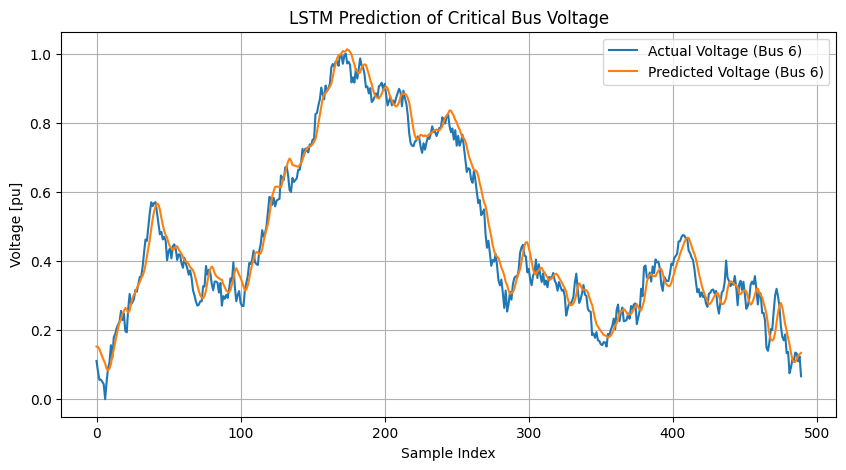

In [ ]:

#مرحله دوم: مدل LSTM بهینه شده با نرمال‌سازی

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# --- بارگذاری داده‌ها ---
data = pd.read_csv("dt_lstm_data.csv")

# --- نرمال‌سازی ---
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# --- آماده‌سازی داده برای LSTM ---
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps, :-1])  # ورودی‌ها (بدون target)
        y.append(data[i+n_steps, 0])      # target: ولتاژ باس 6
    return np.array(X), np.array(y)

n_steps = 10
X, y = create_sequences(scaled_data, n_steps)

# --- ساخت مدل LSTM ---
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# --- آموزش مدل ---
history = model.fit(X, y, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

# --- پیش‌بینی ---
y_pred = model.predict(X)

# --- ترسیم نمودار ---
plt.figure(figsize=(10, 5))
plt.plot(y, label="Actual Voltage (Bus 6)")
plt.plot(y_pred, label="Predicted Voltage (Bus 6)")
plt.title("LSTM Prediction of Critical Bus Voltage")
plt.xlabel("Sample Index")
plt.ylabel("Voltage [pu]")
plt.legend()
plt.grid(True)
plt.show()

Epoch 20/100, Loss: 0.005082
Epoch 40/100, Loss: 0.003936
Epoch 60/100, Loss: 0.003012
Epoch 80/100, Loss: 0.002329
Epoch 100/100, Loss: 0.001792


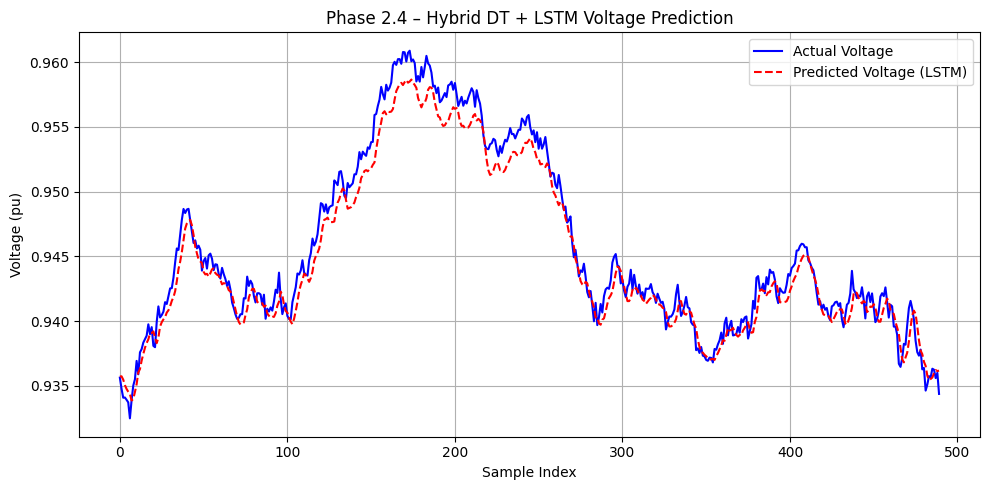

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# ---------- Load Data from Digital Twin ----------
df = pd.read_csv("dt_lstm_data.csv")  # خروجی داده‌های فاز ۲.۱ دیجیتال توین
voltage_data = df["vm_bus6"].values.reshape(-1, 1)  # استفاده از ولتاژ باس ۶

# ---------- Normalize Data ----------
scaler = MinMaxScaler()
voltage_scaled = scaler.fit_transform(voltage_data)

# ---------- Create Dataset Class ----------
class VoltageDataset(Dataset):
    def __init__(self, data, window_size):
        self.data = data
        self.window_size = window_size
        self.length = max(0, len(data) - window_size)  # تضمین می‌کند len ≥ 0

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.window_size]
        y = self.data[idx + self.window_size]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# ---------- Parameters ----------
window_size = 10
batch_size = 16
hidden_size = 32
epochs = 100
lr = 0.001

dataset = VoltageDataset(voltage_scaled, window_size)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# ---------- Define LSTM Model ----------
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out[:, -1, :])
        return out

model = LSTMModel(input_size=1, hidden_size=hidden_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# ---------- Training Loop ----------
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.view(-1, window_size, 1)
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.6f}")

# ---------- Predict on Full Data ----------
model.eval()
inputs = torch.tensor(voltage_scaled, dtype=torch.float32)
predictions = []

for i in range(len(voltage_scaled) - window_size):
    seq_input = inputs[i:i + window_size].view(1, window_size, 1)
    with torch.no_grad():
        pred = model(seq_input).item()
    predictions.append(pred)

# ---------- Denormalize ----------
voltage_real = voltage_data[window_size:].flatten()
voltage_predicted = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

# ---------- Plot ----------
plt.figure(figsize=(10, 5))
plt.plot(voltage_real, label="Actual Voltage", color="blue")
plt.plot(voltage_predicted, label="Predicted Voltage (LSTM)", color="red", linestyle="--")
plt.xlabel("Sample Index")
plt.ylabel("Voltage (pu)")
plt.title("Phase 2.4 – Hybrid DT + LSTM Voltage Prediction")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()